# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/CheloGE/pytorch_project/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [7]:
# the following lines are for using google colab (comment them if you are not using them)
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
##########################
## Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

    100% |████████████████████████████████| 5.6MB 7.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# Downloading data into the workspace
!wget -O zipflower_data https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip  -qq zipflower_data
!stat flower_data #this line only helps to check that the file has been created

--2019-01-02 16:32:01--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘zipflower_data’

zipflower_data      100%[===================>] 297.01M  36.6MB/s    in 8.8s    

2019-01-02 16:32:11 (33.9 MB/s) - ‘zipflower_data’ saved [311442766/311442766]

  File: flower_data
  Size: 4096      	Blocks: 8          IO Block: 4096   directory
Device: 2dh/45d	Inode: 10748925    Links: 4
Access: (0700/drwx------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2018-11-06 15:56:24.000000000 +0000
Modify: 2018-11-06 15:55:18.000000000 +0000
Change: 2019-01-02 16:32:16.122317601 +0000
 Birth: -


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
batch_size = 64
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

valid_transforms = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

In [25]:
""## Counting data
trainpercentage = len(trainloader.dataset)*100/(len(trainloader.dataset)+len(validloader.dataset))
print(f"The lenght of the train dataset is: {len(trainloader.dataset)}, representing {trainpercentage}%")
print(f"The lenght of the valid dataset is: {len(validloader.dataset)}, representing {100-trainpercentage}%")

The lenght of the train dataset is: 6552, representing 88.90094979647219%
The lenght of the valid dataset is: 818, representing 11.09905020352781%


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
## Downloading json file into google colab folder
!wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json -O cat_to_name.json

--2019-01-02 16:33:45--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2019-01-02 16:33:46 (33.6 MB/s) - ‘cat_to_name.json’ saved [2218/2218]



In [11]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(np.array([cat_to_name.items()]).shape)
df = pd.Series(cat_to_name)
df[:]

(1,)


1                  pink primrose
10                 globe thistle
100               blanket flower
101              trumpet creeper
102              blackberry lily
11                    snapdragon
12                   colt's foot
13                   king protea
14                 spear thistle
15                   yellow iris
16                  globe-flower
17             purple coneflower
18                 peruvian lily
19                balloon flower
2      hard-leaved pocket orchid
20         giant white arum lily
21                     fire lily
22             pincushion flower
23                    fritillary
24                    red ginger
25                grape hyacinth
26                    corn poppy
27      prince of wales feathers
28              stemless gentian
29                     artichoke
3               canterbury bells
30                 sweet william
31                     carnation
32                  garden phlox
33              love in the mist
          

#### visualizing images of one batch

In [12]:
cat_to_name['1']

'pink primrose'

In [13]:
df[0]

'pink primrose'

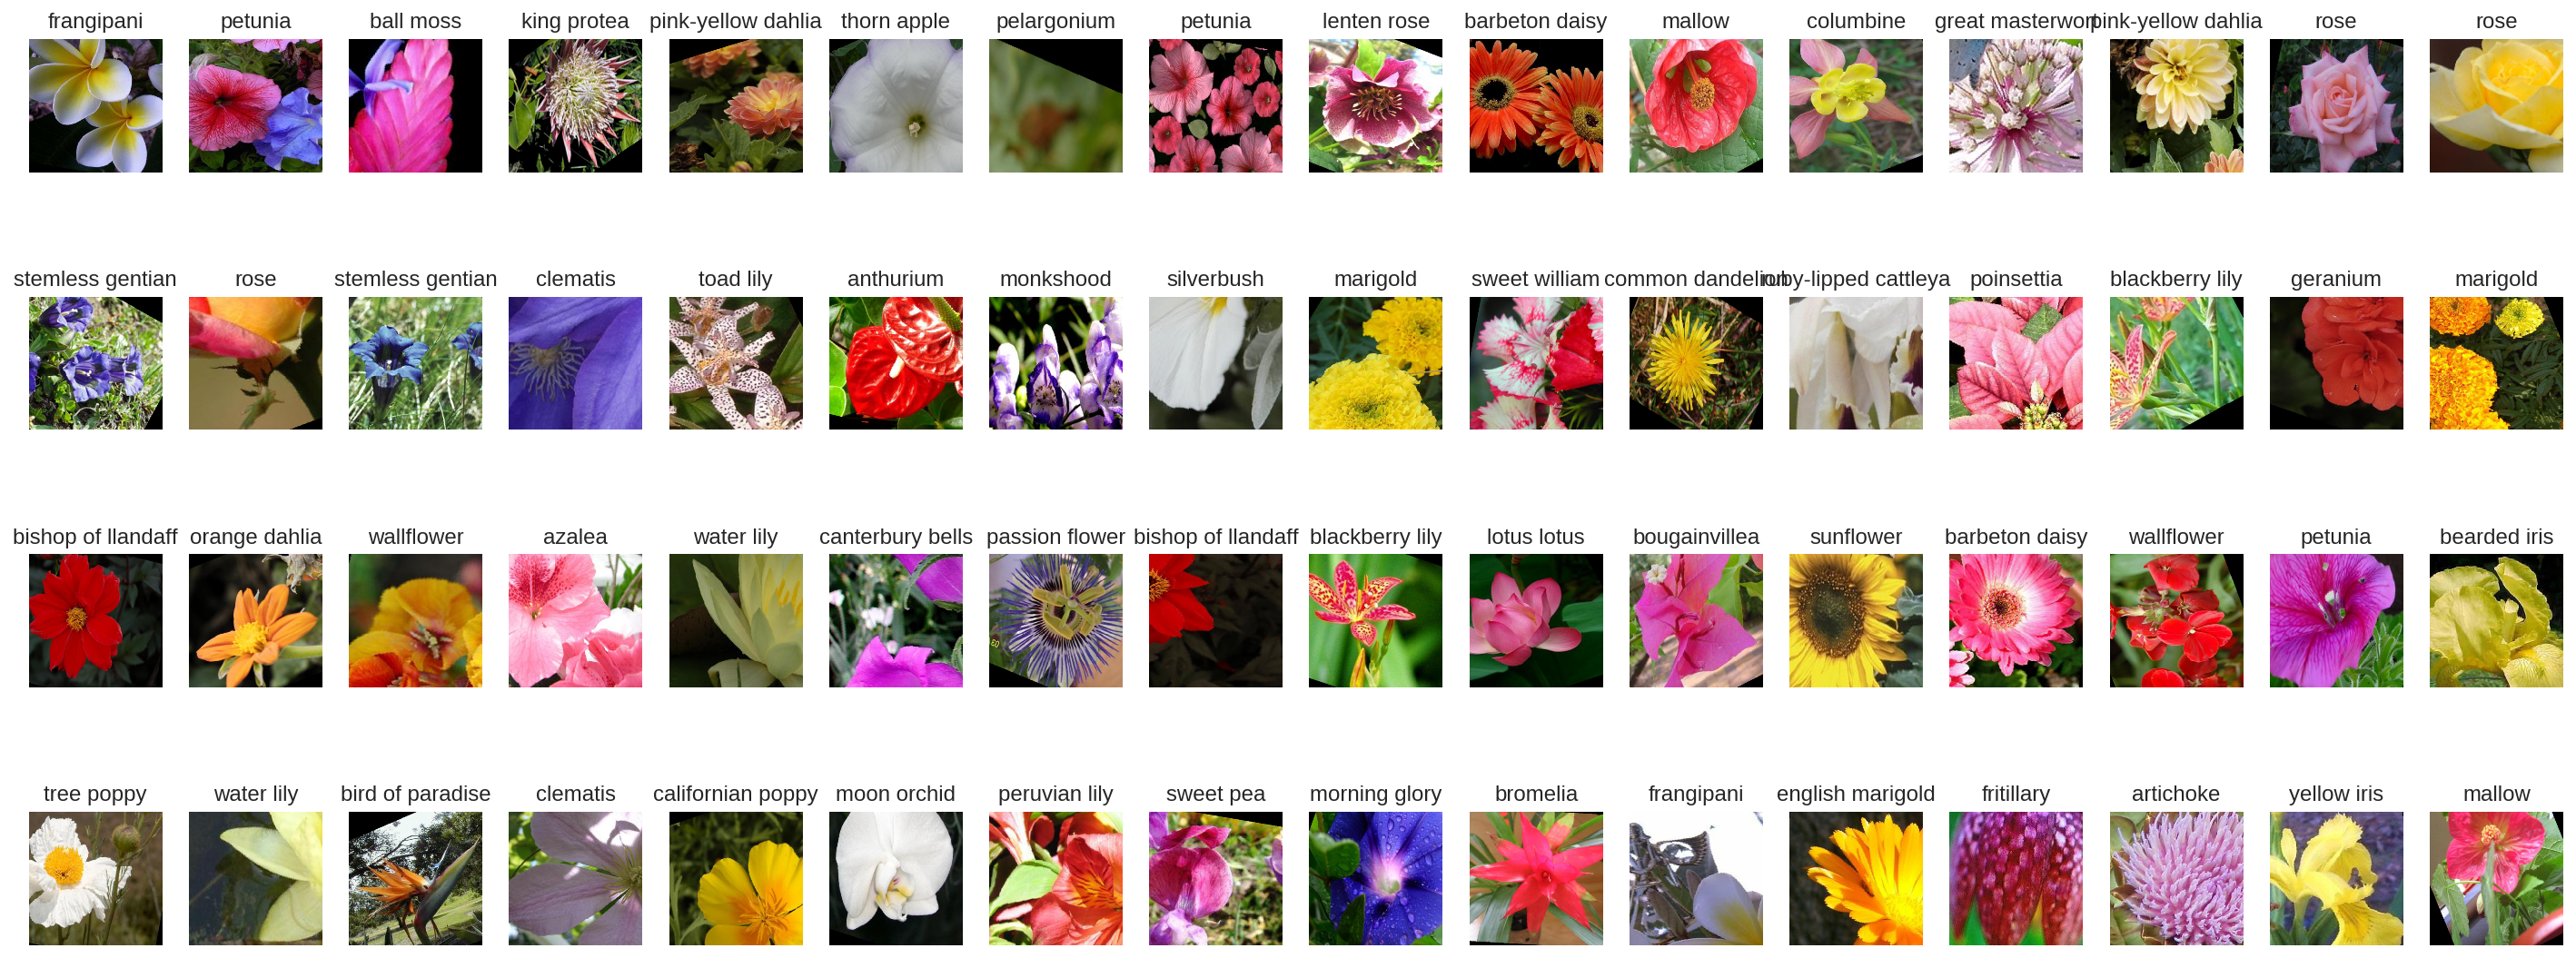

In [14]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(df[int(labels[idx].numpy())])

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 11, 11, 11, 11, 11])


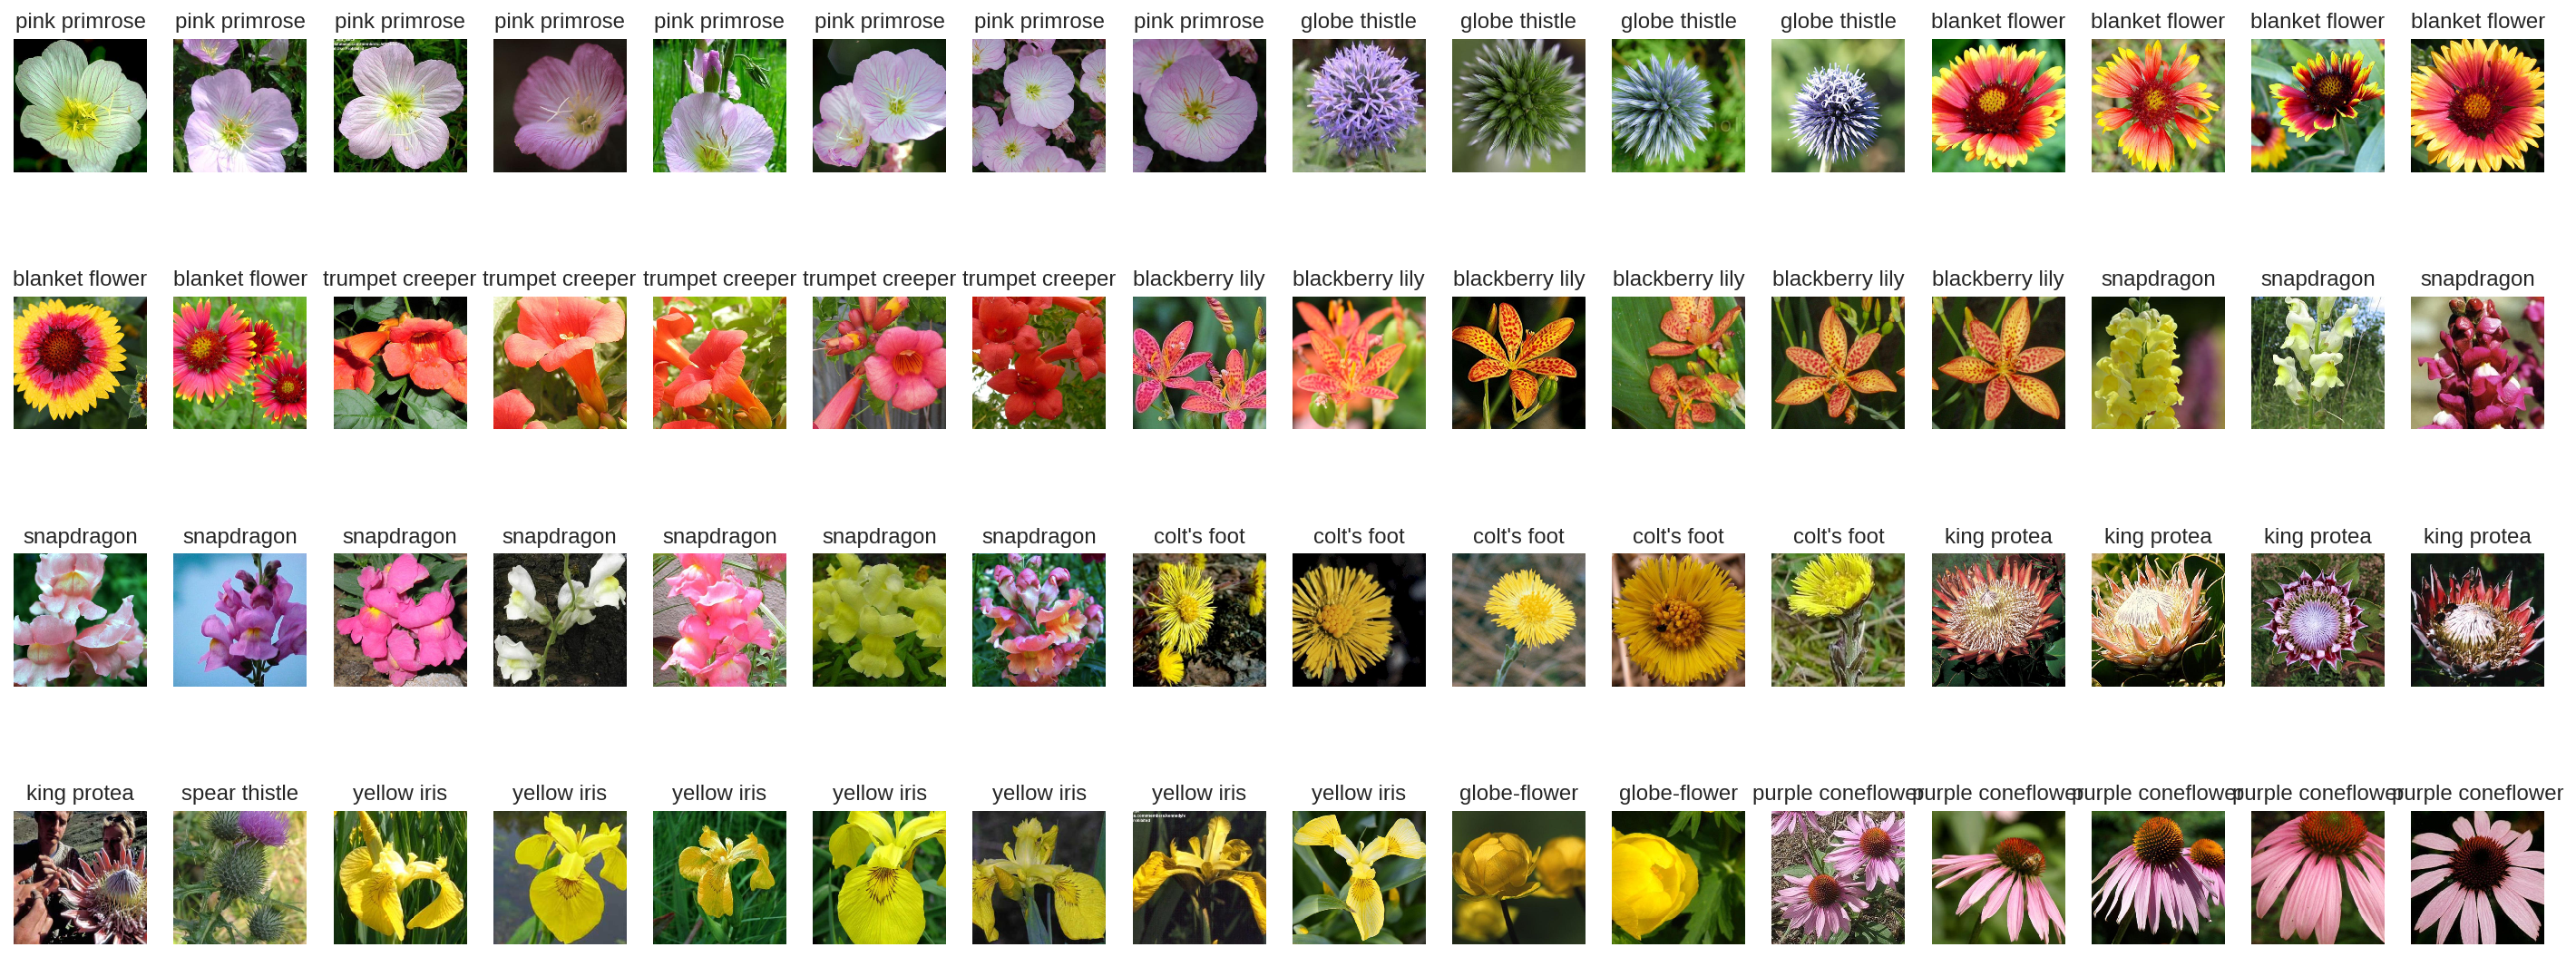

In [15]:
# obtain one batch of training images
dataiter = iter(validloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(labels)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(df[int(labels[idx].numpy())])

In [16]:
## check images shape
images.shape

(64, 3, 299, 299)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Loading [inception](https://pytorch.org/docs/0.4.0/_modules/torchvision/models/inception.html) model and printing out the model architecture

In [17]:
# TODO: Build and train your network
model = models.inception_v3(pretrained=True)
model.aux_logits=False
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 55509600.68it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [18]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1000,bias=True)),
                          ('dropout',nn.Dropout(0.3)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1000, 102)),
                                                    ]))
fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 102,bias=True)),
                                                                ]))
    
model.fc = fc
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [19]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    device = 'cuda'
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
## This function loads a previous model in case we need it to continue training a model
def loadModel(modelFile,model):
  state_dict= torch.load(modelFile)
  model.load_state_dict(state_dict)
  return model

In [21]:
# Download model from dropbox
!wget -O model https://www.dropbox.com/sh/b0gqv5e4p9jz64h/AACc_wyrSbYwGOhQexIt-jHxa?dl=0
!unzip -qq model
!ls

--2019-01-02 16:34:35--  https://www.dropbox.com/sh/b0gqv5e4p9jz64h/AACc_wyrSbYwGOhQexIt-jHxa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/b0gqv5e4p9jz64h/AACc_wyrSbYwGOhQexIt-jHxa [following]
--2019-01-02 16:34:35--  https://www.dropbox.com/sh/raw/b0gqv5e4p9jz64h/AACc_wyrSbYwGOhQexIt-jHxa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc103700bf1876aeaef7a78fbc3a.dl.dropboxusercontent.com/zip_by_token_key?key=AYr96KFzcnBkpvNtavS7F2Upf_DQKLWdbXt-7kdOo0GR_-JmhZWlysZJvHz9MPwpX4lUHaCG6htkmNKiKOXE6XabstW3Xc-Bgs3Ev2SUJlD63aQ8No7VMIfS0cP7zN3MVP1iZ1Nd8fWB1_yPh1rsU6Cy82kHCWHaq1rvYiJNSE-N-jlAFx_Hd_T7Uihf5VtLrChMYGInuQo5EejZQqWctX0D [following]
--2019-01-02 16:34:36--  https://uc103700bf1876aeaef7a78fbc3a.dl.dropboxuser

In [0]:
model = loadModel('myModel.pt', model)

In [31]:
## training the model new classifiers weights
criterion = nn.CrossEntropyLoss()
# Only train the fc parameters, feature parameters are frozen
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.009, eps=0.1)
#optimizer = optim.Adamax(model.fc.parameters(), lr=0.0005)
#optimizer = optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)
#optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001, weight_decay=0.009)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0,amsgrad=True)

model.to(device)
epochs=15
steps = 0
print_every=30
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        steps += 1
        # Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model.forward(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy=0
            model.eval()
            with torch.no_grad(): 
              valid_loss = 0
              stepValid = 0
              for valid_images, valid_labels in validloader:
                  stepValid+=1
                  valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
                  logits = model.forward(valid_images)
                  loss = criterion(logits, valid_labels)
                  valid_loss += loss.item()
                  probabilities=logits.softmax(dim=1)
                  _,topClasses=probabilities.topk(1, dim=1)
                  equals=topClasses==valid_labels.view(*topClasses.shape)
                  accuracy+=torch.mean(equals.type(torch.FloatTensor)) 
              print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.4f}.. "
              f"Valid loss: {valid_loss/len(validloader):.4f}.. "
              f"valid accuracy: {accuracy/len(validloader):.4f}")
              # save model if validation loss has decreased
              if valid_loss <= valid_loss_min:
                  print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
                  torch.save(model.state_dict(), 'myModel1.pt')
                  # Save the checkpoint 
                  checkpoint = {'state_dict': model.state_dict(),
                                'fc': model.fc,
                                'class_to_idx': train_data.class_to_idx,
                                'opt_state': optimizer.state_dict,
                                'num_epochs': epochs}

                  torch.save(checkpoint, 'checkpoint.pth')
                  valid_loss_min = valid_loss
              model.train()
              running_loss = 0

Epoch 1/15.. Train loss: 0.8004.. Valid loss: 0.4461.. valid accuracy: 0.9082
Validation loss decreased (inf --> 5.7999).  Saving model ...
Epoch 1/15.. Train loss: 0.6817.. Valid loss: 0.4289.. valid accuracy: 0.8998
Validation loss decreased (5.7999 --> 5.5760).  Saving model ...
Epoch 1/15.. Train loss: 0.7538.. Valid loss: 0.4121.. valid accuracy: 0.9121
Validation loss decreased (5.5760 --> 5.3569).  Saving model ...
Epoch 2/15.. Train loss: 0.4074.. Valid loss: 0.4099.. valid accuracy: 0.9058
Validation loss decreased (5.3569 --> 5.3286).  Saving model ...
Epoch 2/15.. Train loss: 0.7565.. Valid loss: 0.4041.. valid accuracy: 0.9145
Validation loss decreased (5.3286 --> 5.2537).  Saving model ...
Epoch 2/15.. Train loss: 0.7525.. Valid loss: 0.4428.. valid accuracy: 0.8950
Epoch 3/15.. Train loss: 0.0911.. Valid loss: 0.4047.. valid accuracy: 0.9039
Epoch 3/15.. Train loss: 0.7931.. Valid loss: 0.3923.. valid accuracy: 0.9025
Validation loss decreased (5.2537 --> 5.1002).  Saving

In [32]:
!ls

anna.txt	  flower_data  myModel1.pt  sample_data
cat_to_name.json  labels.txt   myModel.pt   zipflower_data
checkpoint.pth	  model        reviews.txt


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
'''
# Save the checkpoint 
checkpoint = {'state_dict': model.state_dict(),
              'fc': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, 'checkpoint.pth')
'''


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    # Checkpoint for when using GPU
    checkpoint = torch.load(filepath)
    
    # Checkpoint for when using CPU
    #checkpoint = torch.load(filepath, map_location=cpu)
    
    model.load_state_dict(checkpoint['state_dict'])
    model.fc = checkpoint['fc'] 
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [0]:
load_checkpoint('checkpoint.pth')

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # Converting image to (Python Imaging Library)PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')
    transforms = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])
    # Apply transforms to the PIL image
    pil_transformed = transforms(pil_im)
    
    # Converting to Numpy array 
    image_data = np.array(pil_tfd)
    
    return image_data
  
## Test Process a PIL image for use in a PyTorch model
img = (data_dir + '/test' + '/1/' + 'image_06752.jpg')
img = process_image(img)
print(img.shape)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
imshow(process_image("flowers/test/1/image_06743.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    model.eval()
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        model.train()
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [0]:
img = (data_dir + '/test' + '/10/' + 'image_07104.jpg')
probabilities, classes = predict(img, model)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/CheloGE/pytorch_project/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes

 Display an image along with the top 5 classes
def check_sanity(image_path,model):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1

    probabilities = predict(image_path, model)
    image = process_image(image_path)
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

In [0]:
img = (data_dir + '/test' + '/10/' + 'image_07104.jpg')

check_sanity(img, model)